In [1]:
import os
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import h5py
import imageio.v2 as imageio

### Tensor

In [3]:
a = torch.ones(3)
a

tensor([1., 1., 1.])

In [4]:
a[1]

tensor(1.)

In [5]:
a[2] = 0.0
a

tensor([1., 1., 0.])

In [6]:
img_t = torch.randn(3, 5, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


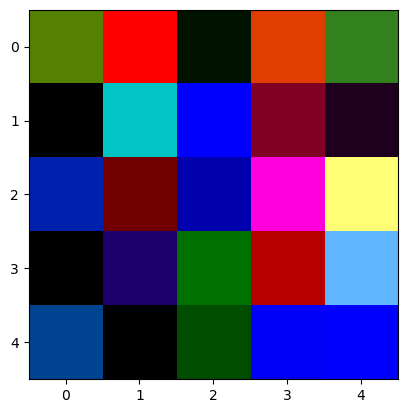

In [7]:
plt.imshow(img_t.permute(1, 2, 0).numpy())

In [8]:
img_gray_naive = img_t.mean(-3) # in case there is a batch dimension

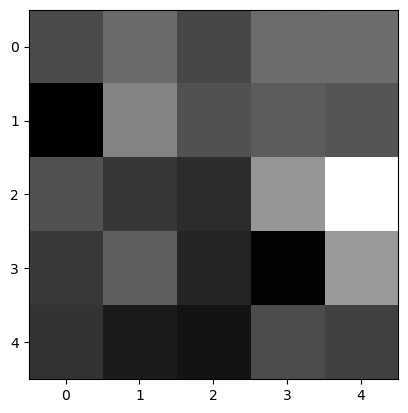

In [9]:
plt.imshow(img_gray_naive.numpy(), cmap="gray")

In [10]:
weights = torch.tensor([0.2126, 0.7152, 0.0722])
unsqueezed_weights = weights.unsqueeze(-1).unsqueeze(-1)
unsqueezed_weights.shape

torch.Size([3, 1, 1])

In [11]:
batch_t = torch.randn(2, 3, 5, 5)
batch_t = torch.randn(2, 3, 5, 5)

### Modifying stored values: In-place operations

They are recognizable from a trailing underscore in their name, like zero_, which indicates that the method operates in place by modifying the input instead of creating a new output tensor and returning it. For instance, the zero_ method zeros out all the elements of the input. Any method without the trailing underscore leaves the source tensor unchanged and instead returns a new tensor:

In [2]:
a = torch.ones(3, 2)
a.zero_()
a

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [9]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 6]

In [22]:
points.stride()

(2, 1)

In [18]:
second_point = points[1]
second_point

tensor([5., 3.])

In [19]:
second_point.storage_offset()

2

In [21]:
second_point.size(), second_point.shape

(torch.Size([2]), torch.Size([2]))

This indirection between Tensor and Storage makes some operations inexpensive, like transposing a tensor or extracting a subtensor, because they do not lead to memory reallocations.

But changing the subtensor will have a side effect on the original tensor! This might not always be desirable, so we can eventually clone the subtensor into a
new tensor:

In [23]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1].clone()
second_point[0] = 10.0
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

Some tensor operations in PyTorch only work on contiguous tensors, such as view, which we’ll encounter in the next chapter. In that case, PyTorch will throw an informative exception and require us to call contiguous explicitly.

In [24]:
points.is_contiguous()

True

In [35]:
points_t = points.t()
points_t, points_t.is_contiguous()

(tensor([[4., 5., 2.],
         [1., 3., 1.]]),
 False)

We can obtain a new contiguous tensor from a non-contiguous one using the contiguous
method. The content of the tensor will be the same, but the stride will change, as
will the storage:

In [39]:
points_t_cont = points_t.contiguous()

In [41]:
# Reshuffled
torch.Tensor([points_t_cont.storage(), points.storage()])

tensor([[4., 5., 2., 1., 3., 1.],
        [4., 1., 5., 3., 2., 1.]])

### Serializing tensors

In [45]:
torch.save(points, './points.t')

In [46]:
points = torch.load('./points.t')
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

##### Exercises

In [60]:
a = torch.Tensor(range(9))
a

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [59]:
b = a.view(3, 3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [61]:
id(a.storage()) == id(b.storage())

True

In [62]:
c = b[1:, 1:]
c

tensor([[4., 5.],
        [7., 8.]])

In [65]:
c.shape

torch.Size([2, 2])

In [64]:
c.storage_offset()

4

In [67]:
c.stride()

(3, 1)

In [68]:
torch.sqrt(c)

tensor([[2.0000, 2.2361],
        [2.6458, 2.8284]])

In [74]:
torch.sqrt_(a)
a

tensor([0.0000, 1.0000, 1.4142, 1.7321, 2.0000, 2.2361, 2.4495, 2.6458, 2.8284])

### Image to Tensor

In [3]:
img_arr = imageio.imread('.././pretrained-models/data/bobby.jpg')
img_arr.shape

C:\Users\Cyrille\AppData\Local\Temp\ipykernel_15060\2605221410.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread('.././pretrained-models/data/bobby.jpg')


(720, 1280, 3)

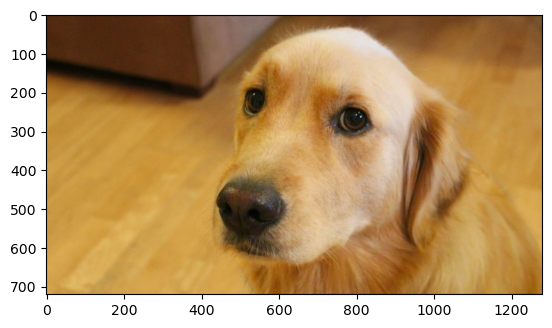

In [4]:
plt.imshow(img_arr)

In [8]:
img = torch.from_numpy(img_arr)
out = img.permute(2,0,1)
out.shape

torch.Size([3, 720, 1280])

### Loading multiple images

In [14]:
data_dir = './image-cats/'
filenames = [name for name in os.listdir(data_dir)
             if os.path.splitext(name)[-1] == '.png']
filenames

['cat1.png', 'cat2.png', 'cat3.png']

In [17]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2,0,1)
    img_t = img_t[:3]
    batch[i] = img_t

In [24]:
batch = batch.float()
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


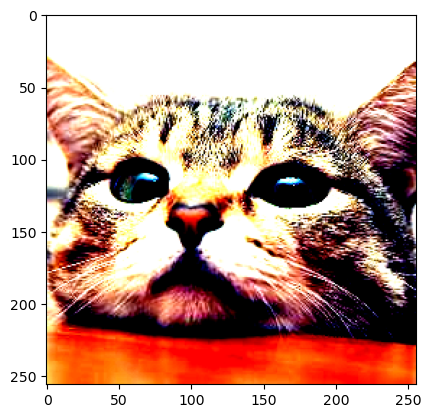

In [28]:
plt.imshow(batch[2].permute(1,2,0))

### Volumetric data

In [2]:
dir_path = "./volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%8/99 files (8.1%16/99 files (16.2%24/99 files (24.2%32/99 files (32.3%39/99 files (39.4%47/99 files (47.5%56/99 files (56.6%65/99 files (65.7%73/99 files (73.7%82/99 files (82.8%91/99 files (91.9%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 35/99  (35.477/99  (77.899/99  (100.0%)


(99, 512, 512)

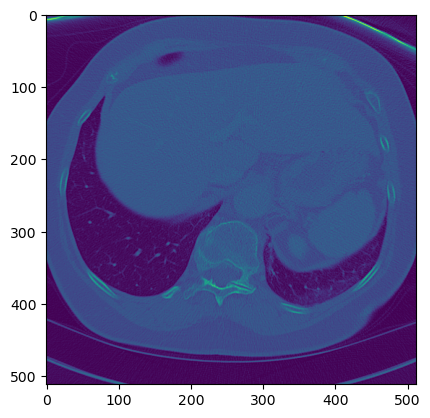

In [6]:
plt.imshow(vol_arr[80])

In [8]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
vol.shape

torch.Size([1, 99, 512, 512])

### Tabular data

In [2]:
wine_path = "./tabular-wine/winequality-white.csv"
df = pd.read_csv(wine_path, sep=";", decimal=".")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, 
                         delimiter=";", skiprows=1)
# Skip column names row
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [4]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [19]:
data = wineq[:, :-1] # Everything but the target
target = wineq[:, -1].long() 
data.shape, target.shape

(torch.Size([4898, 11]), torch.Size([4898]))

In [28]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
target_onehot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [32]:
data_mean = torch.mean(data, dim=0)
data_std = torch.std(data, dim=0)

In [34]:
data_norm = (data - data_mean) / data_std
torch.mean(data_norm, dim=0)[0], torch.std(data_norm, dim=0)[0]

(tensor(-1.8147e-07), tensor(1.))

### Time series data

In [5]:
bikes_path = "./bike-sharing-dataset/hour-fixed.csv"
df = pd.read_csv(bikes_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [10]:
bikes_numpy = np.loadtxt(bikes_path,
                         dtype=np.float32,
                         delimiter=",",
                         skiprows=1,
                         converters={1: lambda x: float(x[8:10])})
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

In [11]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [12]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

Calling view on a tensor returns a new tensor
that changes the number of dimensions and the striding information, without
changing the storage. This means we can rearrange our tensor at basically zero cost,
because no data will be copied. Our call to view requires us to provide the new shape
for the returned tensor. We use -1 as a placeholder for “however many indexes are
left, given the other dimensions and the original number of elements.”

### Text data

In [2]:
with open("./jane-austen/1342-0.txt", encoding="utf8") as f:
    text = f.read()

In [3]:
lines = text.split("\n")
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

In [4]:
letter_t = torch.zeros(len(line), 128)
letter_t.shape

torch.Size([70, 128])

##### One-hot encoding charactes

In [7]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0
    letter_t[i][letter_index] = 1
letter_t

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])